In [188]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer

sns.set_theme('notebook', 'whitegrid', 'dark')

In [189]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
groups_train = np.load('../data/groups_train.npy')
severities_train = np.load('../data/severities_train.npy')

In [190]:
pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w_list=[13, 64, 1845], n_samples=100, n_frequencies=20)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=37)),
    ('svm', SVC(probability=True, kernel='linear', C=91.31))
])

pipeline.fit(X_train, y_train);

In [191]:
y_pred_train = pipeline.predict(X_train)
y_pred_proba_train = pipeline.predict_proba(X_train)

In [192]:
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
groups_test = np.load('../data/groups_test.npy')
severities_test = np.load('../data/severities_test.npy')

In [193]:
y_pred_test = pipeline.predict(X_test)
y_pred_proba_test = pipeline.predict_proba(X_test)

In [194]:
X_cvd = np.load('../data/X_cvd.npy')
y_cvd = np.load('../data/y_cvd.npy')
groups_cvd = np.load('../data/groups_cvd.npy')

X_cvd = X_cvd[y_cvd == 0]
groups_cvd = groups_cvd[y_cvd == 0]
y_cvd = np.abs(y_cvd[y_cvd == 0] - 1)

In [195]:
y_pred_cvd = pipeline.predict(X_cvd)
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

In [196]:
y_pred_no_cvd =  y_pred_test[y_test == 0]
y_pred_proba_no_cvd = y_pred_proba_test[y_test == 0]

y_combined = np.concatenate((np.ones(y_pred_cvd.shape[0]), np.zeros(y_pred_no_cvd.shape[0])))
y_pred_combined = np.concatenate((y_pred_cvd, y_pred_no_cvd))
y_pred_proba_combined = np.concatenate((y_pred_proba_cvd[:, 1], y_pred_proba_no_cvd[:, 1]))

Accuracy: 77.50%
Recall: 76.92%
Precision: 76.92%
F1: 76.92%
AUC ROC: 86.49%


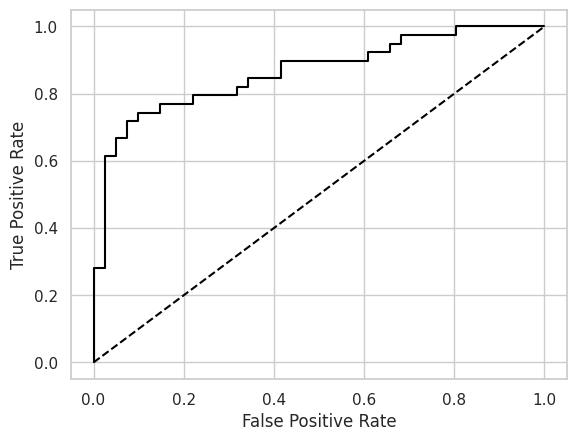

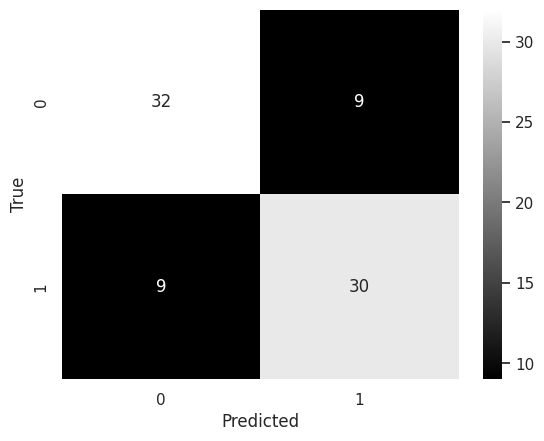

In [199]:
accuracy = np.mean(y_pred_combined == y_combined)
print(f'Accuracy: {accuracy:.2%}')

recall = np.sum(np.logical_and(y_combined, y_pred_combined)) / np.sum(y_combined)
print(f'Recall: {recall:.2%}')

precision = np.sum(np.logical_and(y_combined, y_pred_combined)) / np.sum(y_pred_combined)
print(f'Precision: {precision:.2%}')

f1 = 2 * precision * recall / (precision + recall)
print(f'F1: {f1:.2%}')

auc_roc = roc_auc_score(y_combined, y_pred_proba_combined)
print(f'AUC ROC: {auc_roc:.2%}')

fpr, tpr, thresholds = roc_curve(y_combined, y_pred_proba_combined)
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_combined, y_pred_combined)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()